In [1]:
import osmnx as ox
from geopy.distance import geodesic
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from tqdm import tqdm

In [ ]:
## 그래프 예시

# from geopy.distance import geodesic
# import networkx as nx

# # 노드 정의
# locations = {
#     "A": (37.492, 127.01),
#     "B": (37.493, 127.012),
#     "C": (37.495, 127.015)
# }

# G = nx.Graph()
# for name, coord in locations.items():
#     G.add_node(name, lat=coord[0], lon=coord[1])

# # 거리 기반 엣지 추가
# for n1 in locations:
#     for n2 in locations:
#         if n1 != n2:
#             dist = geodesic(locations[n1], locations[n2]).meters
#             G.add_edge(n1, n2, distance=dist)


노드 수: 3057, 엣지 수: 8550


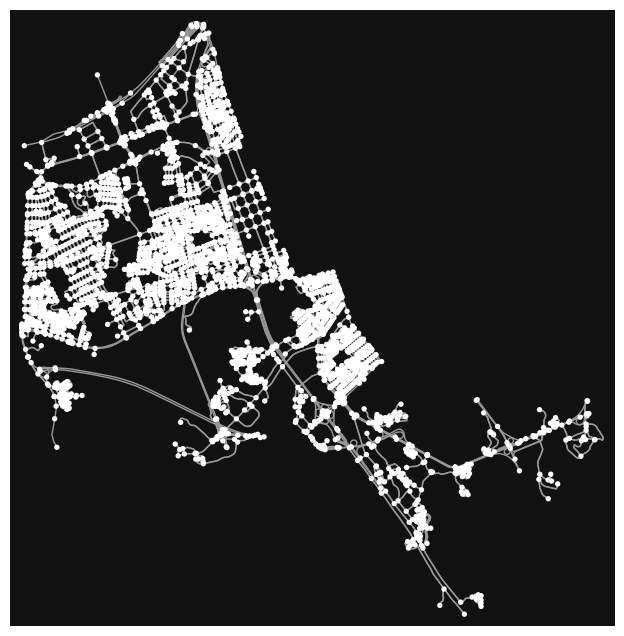

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
# 1. 서초구의 도로망 그래프 불러오기
G = ox.graph_from_place("Seocho-gu, Seoul, South Korea", network_type='drive')

# 2. 기본 정보 출력
print(f"노드 수: {len(G.nodes)}, 엣지 수: {len(G.edges)}")

# 3. 시각화 (선택)
ox.plot_graph(G, figsize=(8,8))

In [ ]:
# 전국 cctv 정보
cctv_info = pd.read_excel("../../../Data/전국CCTV표준데이터.xlsx")
cctv_info.head(3)

In [ ]:
# 1. 서초구 도로망 가져오기
G = ox.graph_from_place("Seocho-gu, Seoul, South Korea", network_type='drive')

# 2. 그래프 → GeoDataFrame 변환
nodes, edges = ox.graph_to_gdfs(G)

# 3. 지도 생성
seocho_center = [37.4836, 127.0326]
m = folium.Map(location=seocho_center, zoom_start=13)

# 4. 도로 엣지 시각화 (파란 선)
for _, row in edges.iterrows():
    coords = [(lat, lon) for lon, lat in row['geometry'].coords]
    folium.PolyLine(locations=coords, color='blue', weight=2, opacity=0.6).add_to(m)

# 5. 노드 시각화 (초록 점)
for node_id, row in nodes.iterrows():
    lat, lon = row['y'], row['x']
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color='green',
        fill=True,
        fill_opacity=0.7,
        popup=f"Node ID: {node_id}"
    ).add_to(m)

# 6. CCTV 마커 시각화 (빨간 마커)
cctv_info = pd.read_excel("../../../Data/전국CCTV표준데이터.xlsx")
seocho_cctv = cctv_info[cctv_info['소재지도로명주소'].str.contains("서초구", na=False)]

for _, row in seocho_cctv.iterrows():
    lat, lon = row['WGS84위도'], row['WGS84경도']
    popup_text = f"{row['소재지도로명주소']}<br>카메라: {row['카메라대수']}대"
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color='red', icon='camera')
    ).add_to(m)

# 7. 저장 또는 출력
m.save("seocho_full_graph_with_cctv_nodes.html")
m

In [ ]:
# 서초구 개별 주정차단속 현황
illegal_info = pd.read_csv("../../../Data/2201-2312개별서초구주정차단속현황.csv", encoding='cp949')
illegal_info = illegal_info[illegal_info['단속장소'].notnull()]

# test 데이터 분리 (23.12월 자료)
# illegal_info = illegal_info[illegal_info['단속일시'].notnull()]
illegal_info.head(3)

In [ ]:
tqdm.pandas()

def get_latlon_from_address(address):
    try:
        loc = ox.geocode(address)
        return loc[0], loc[1]
    except:
        return None, None
    
illegal_info[['lat', 'lon']] = illegal_info['단속장소'].progress_apply(lambda x: pd.Series(get_latlon_from_address(x)))

In [ ]:
G = ox.graph_from_place("Seocho-gu, Seoul, South Korea", network_type='drive')

illegal_info['node'] = illegal_info.apply(lambda row: ox.distance.nearest_nodes(G, row['lon'], row['lat']) if pd.notnull(row['lat']) else None, axis=1)

